In [1]:
import pysal
import geopandas as gpd
# import arcpy
from pysal.model import mgwr
import pandas as pd
import numpy as np
import os
import datetime as dt 
import math


# Visualization 
from pprint import pprint # Pretty printing
import seaborn as sns # better plotting
import matplotlib.pyplot as plt # basic plotting
from matplotlib import colors # For colormap creation 
import contextily as ctx # For basemaps

In [2]:
# Load Csv's 

cwd = os.getcwd()

data_path = os.path.join(cwd,'..', '..', 'data')
# arcpy.env.workspace = os.path.join(cwd, '..', '..', 'data', 'QAQC.gdb')

# Modeling dataframe

modeling_df = pd.read_csv(os.path.join(data_path, 'Parameter_df.csv'))

modeling_df['date'] = pd.to_datetime(modeling_df.date)

# Station Locations

stations_df = pd.read_csv(os.path.join(data_path, 'stations_5-2.csv'))

In [3]:
# Get previous day

previous_dates = modeling_df.date.dt.date - dt.timedelta(1)

for i, row in modeling_df.iterrows():
    
    previous_date = previous_dates.loc[i]
    
    sensor_id = row.sensor_index
    
    previous_readings = modeling_df[(modeling_df.date.dt.date == previous_date)&
                                   (modeling_df.sensor_index == sensor_id)].pm25_fullDay_mean
    
    if len(previous_readings) == 1:

        modeling_df.loc[i, 'pm25_fullDay_mean_yesterday'] = previous_readings.iloc[0]

    
modeling_df.head()

sensor_index       date  is_weekday  n_observations  pm25_fullDay_mean  \
0        143656 2023-03-18           0             144           5.341125   
1        142774 2022-11-05           0             144           8.901722   
2        145454 2022-12-06           1             144          11.355750   
3        142748 2022-12-07           1             144          11.848437   
4        143636 2023-01-22           0             144          24.739590   

   pm25_fullDay_minutesAbove12ug  n_spikes  humidity_fullDay_mean  \
0                            190         0                 45.833   
1                            370         0                 62.438   
2                            690         2                 48.174   
3                            560         3                 53.589   
4                           1440        50                 60.596   

   temperature_fullDay_mean  pressure_fullDay_mean  idwSum_facilities  \
0                    23.505                988.205           0.005054   
1                    42.682                973.451           0.004609   
2                    26.181                987.556          67.350629   
3                    25.477                994.330           2.827060   
4                    28.776                983.963          24.669941   

   idwSum_traffic  pm25_fullDay_mean_yesterday  
0      861.930809                     4.240750  
1      452.986261                    13.551993  
2      587.483355                     8.880667  
3     3827.349398                     7.053014  
4      453.501189                    13.688465

In [4]:
def plot_GWR(data, predictors, title):
    '''This function will plot GWR Results and save the figure
    The data should have all the betas associated with the predictors (predictor_beta)
    As well as R^2 (r2)'''
    
    # Plot Betas and R^2
    
    db_to_plot = data.copy()
    
    # Figure out figure layout
    
    n_plots = len(predictors) + 2 # Predictors, constant, and R^2
    
    if n_plots == 4:
        f,axs=plt.subplots(2,2, figsize=(18,18),subplot_kw=dict(aspect='equal')) # initialize a figure
    elif n_plots == 6:
        f, axs = plt.subplots(2,3, figsize = (27,18), subplot_kw=dict(aspect='equal'))
    elif n_plots < 4:
        f,axs=plt.subplots(1,n_plots, figsize=(18,6),subplot_kw=dict(aspect='equal'))
    elif n_plots < 9:
        f,axs=plt.subplots(3,math.ceil(n_plots/3), figsize=(27,27),subplot_kw=dict(aspect='equal'))
    else:
        f,axs=plt.subplots(1, n_plots, figsize=(18,18),subplot_kw=dict(aspect='equal'))
    
    # Plot each beta
        
    for i, ax in enumerate(axs.flatten()): # Loop through subplots
        
        # Check which column
        
        if i == len(predictors) + 1: 
            break # Break out of loop for final plot (R^2)
        
        elif i == 0:
            column_name = 'constant_beta'
        else:
            column_name = predictors[i-1]+'_beta'
            
        # Create the colormap for the betas
        
        betas = db_to_plot[column_name].values
        
        vmin = min(betas)
        vmax = max(betas)
        
        if vmin >= 0:
            vcenter = np.median(betas)
            cmap = 'YlGn'
            
        elif vmin < 0 and vmax > 0:
            vcenter = 0
            cmap = 'PiYG'
        else:
            vcenter = np.median(betas)
            cmap = 'RdPu_r'

        norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
        
        db_to_plot.plot(column=column_name,cmap=cmap,marker='.',ax=ax,legend=True,
                        norm = norm, s=500) # Plot beta_i's
        # Add colorbar, make sure to specify tick locations to match desired ticklabels

        # base map
        ctx.add_basemap(ax, 
                    crs=data.crs, 
                    # source=ctx.providers.Stamen.TonerHybrid,
                    source = ctx.providers.CartoDB.DarkMatter,
                    zorder=-1, # plot behind all other plots
                    alpha=0.5
                   )

        # set the title of the plot to be the name of the variable:
        if i==0:
            ax.set_title(r'$\beta$ of Constant',fontsize=16)
        else: 
            ax.set_title(r'$\beta$ of '+ predictors[i-1],fontsize=16)


    # Get the last subplot index
    
    diff = len(axs.flatten()) - n_plots - 1

    mid_last_index = -math.ceil(diff/2) - 1
    
    last_ax = axs.flatten()[mid_last_index] # Get last subplot

    db_to_plot[db_to_plot['r2'] > 0].plot(column='r2', cmap='Reds', ax = last_ax,
                                legend=True, marker='.', s=500,
                               vmin = 0, vmax=1) # plot R^2 values

    # base map
    ctx.add_basemap(ax = last_ax,
                    crs=data.crs,
                    source=ctx.providers.Stamen.TonerHybrid,
                    zorder=-1,
                    alpha=0.5)

    # title
    last_ax.set_title(r'local $R^2$',fontsize=16)
    
    # Remove all axes
    
    for ax in axs.flatten():
        
        ax.set_axis_off() # Remove Axis labels

    f.tight_layout() # we are done!
    f.savefig(title)
    plt.show()

## Prep for Modeling

Mean:  986.0165674404642 
Std:  9.410231526092586


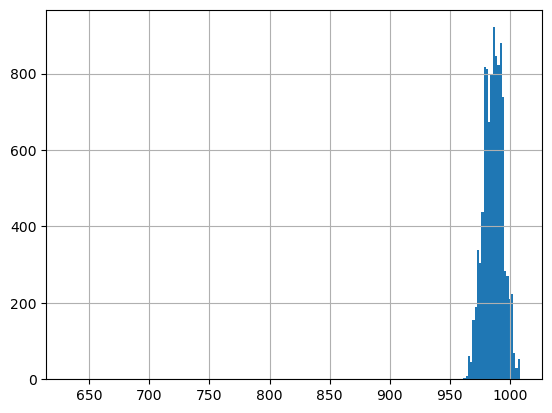

In [5]:
# Check out pressure and fix for model? <- NOT DONE

press = modeling_df.pressure_fullDay_mean

mean = press.mean()
std = press.std()

print('Mean: ', press.mean(),
      '\nStd: ', press.std())

press.hist(bins = 200)

# I think we will remove any outside of 4 standard deviations

press_range = [mean - 3*std, mean + 3*std]

In [6]:
# Clean data

# Remove pm2.5 values greater than 28
# And pressure inversions 

# ^ Nah

modeling_df_select = modeling_df#[
    # (modeling_df.pm25_fullDay_mean < 28)&
                                 # (modeling_df.pressure_fullDay_mean > press_range[0])&
                                  # (modeling_df.pressure_fullDay_mean < press_range[1])
                                  # ].copy()

# Making pressure on similar scale as other variables

# modeling_df_select['pressure_fullDay_mean'] = modeling_df.pressure_fullDay_mean/10

no_nans = modeling_df_select.dropna().copy() # Drop NA

# Add month

no_nans['month'] = no_nans.date.dt.month.astype(str)

print(len(no_nans), len(modeling_df_select))

len(no_nans.sensor_index.unique())

9857 10372


54

In [7]:
# Merge the stations

merged_df = pd.merge(stations_df, no_nans, on='sensor_index')

merged_no_nans = merged_df.dropna().copy() # Drop nans

In [8]:
# Map the season into dataframe

seasonMonth_dict = {'Winter':[12,1,2],
                    'Spring':[3,4,5],
                    'Summer':[6,7,8],
                    'Fall':[9,10,11]}

for season in seasonMonth_dict:
    
    seasonMonths = seasonMonth_dict[season]
    
    is_season = merged_no_nans.date.dt.month.isin(seasonMonths)
    
    merged_no_nans.loc[is_season, 'season'] = season

## GWR for all Different combinations of Predictors
(By Season)

In [9]:
from itertools import chain, combinations

# These will be the predictors

predictors = [ # Independents
    'humidity_fullDay_mean', 
           'pm25_fullDay_mean_yesterday',
            'temperature_fullDay_mean',
           'pressure_fullDay_mean',
           'idwSum_facilities', 'idwSum_traffic'
    ]

# All combinations of 2 or more

combos = chain(*map(lambda x: combinations(predictors, x), range(2, len(predictors)+1)))

print(len(list(combos)), 'Combinations')

# Giving them IDs

combos_dict = dict(zip(range(len(list(chain(*map(lambda x: combinations(predictors, x), range(2, len(predictors)+1)))))),
                       list(chain(*map(lambda x: combinations(predictors, x), range(2, len(predictors)+1))))))

# ^ To see what that's all about go here:
# https://stackoverflow.com/questions/464864/get-all-possible-2n-combinations-of-a-list-s-elements-of-any-length

57 Combinations


In [10]:
# GWRs 

# Set bandwidth

bw = 4000 # meters

# Define Iterable

seasons = ['Winter', 'Spring', 'Summer', 'Fall', 'All']

# Initialize Storage

model_dict = {}

for season in seasons:
    
    model_dict[season] = {}
    
    # Select season
    
    if season == 'All':
        
        select = merged_no_nans
    
    else:
        select = merged_no_nans[merged_no_nans.season == season]

    # Prepare data for GWR function

    ## Get UTM Coordinates

    utm_gdf = gpd.GeoDataFrame(select, geometry = gpd.points_from_xy(select.longitude,
                                                                          select.latitude,
                                                                          crs = 'EPSG:4326')
                                  ).to_crs('EPSG:26915')

    model_dict[season]['utm_gdf'] = utm_gdf.copy()

    coords = np.array(list(zip(utm_gdf.geometry.x, utm_gdf.geometry.y)))
    
    # Iterate through combinations
    
    for combo_id in combos_dict:

        # Get arrays of the variables
        
        x_list = list(combos_dict[combo_id])
        
        if x_list != ['idwSum_facilities', 'idwSum_traffic']: # Causes matrix to be singular

            y = select.pm25_fullDay_mean.values.reshape(-1, 1)
            X = select[x_list].values

            model = mgwr.gwr.GWR(coords = coords,
                                y = y,
                                X = X,
                                fixed = True,
                                bw = bw)


            results = model.fit()

            # Store the model

            model_key = str(combo_id) + '_model'

            model_dict[season][model_key] = results
            
            # print(model_key)
    print(season)

Winter
Spring
Summer
Fall
All


In [11]:
# Unpack those results!

# https://mgwr.readthedocs.io/en/latest/generated/mgwr.gwr.GWRResults.html

cols =  ['season', 'combo_id', 'rmse', 'rsquared', 'aic', 'bic']

results_df = pd.DataFrame(columns = cols)

season_bests = {}

for season in model_dict:
    
    season_best = (None, 0, float('inf')) # Combo_id, R^2, AIC
    
    for combo_id in model_dict[season]:
        
        if combo_id != 'utm_gdf':
            
            results = model_dict[season][combo_id]
            
            predicted = results.predy
                
            rmse = np.sum((results.y - predicted.T)**2/len(results.y))
            
            r2 = results.R2
            
            aic = results.aic

            row = [season, combo_id, rmse, r2, aic, results.bic]

            results_df.loc[len(results_df)] = row
            
            # Pick best model
            # https://www.scribbr.com/statistics/akaike-information-criterion/
            
            if r2 > season_best[1]:
                
                if aic < season_best[2]:
                    
                    season_best = (combo_id, r2, aic)
                    
    season_bests[season] = season_best

In [12]:
season_bests

{'Winter': ('35_model', 0.5454064709636095, 26795.171977661408),
 'Spring': ('0_model', 0.16621187861576459, 17757.53532869302),
 'Summer': ('51_model', 0.22729137034564673, 7066.257797300925),
 'Fall': ('0_model', 0.35169539988727605, 17744.58596779262),
 'All': ('0_model', 0.4818445917165416, 72036.3031110755)}

In [13]:
# Winter model

combos_dict[35]

('humidity_fullDay_mean',
 'pm25_fullDay_mean_yesterday',
 'temperature_fullDay_mean',
 'pressure_fullDay_mean')

In [14]:
# Summer model

combos_dict[51]

('humidity_fullDay_mean',
 'pm25_fullDay_mean_yesterday',
 'temperature_fullDay_mean',
 'pressure_fullDay_mean',
 'idwSum_traffic')

In [15]:
# Fall, All, Spring Model

combos_dict[0]

('humidity_fullDay_mean', 'pm25_fullDay_mean_yesterday')

## Check out the Best

Winter 

~~~~~~~


Dependent Variables: 
 humidity_fullDay_mean
pm25_fullDay_mean_yesterday
temperature_fullDay_mean
pressure_fullDay_mean 


Model type                                                         Gaussian
Number of observations:                                                3420
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         495905.524
Log-likelihood:                                                  -13363.004
AIC:                                                              26736.007
AICc:                                                             26738.032
BIC:                                                             468116.317
R2:                                                                   0.542
Adj. R2:                                                              0

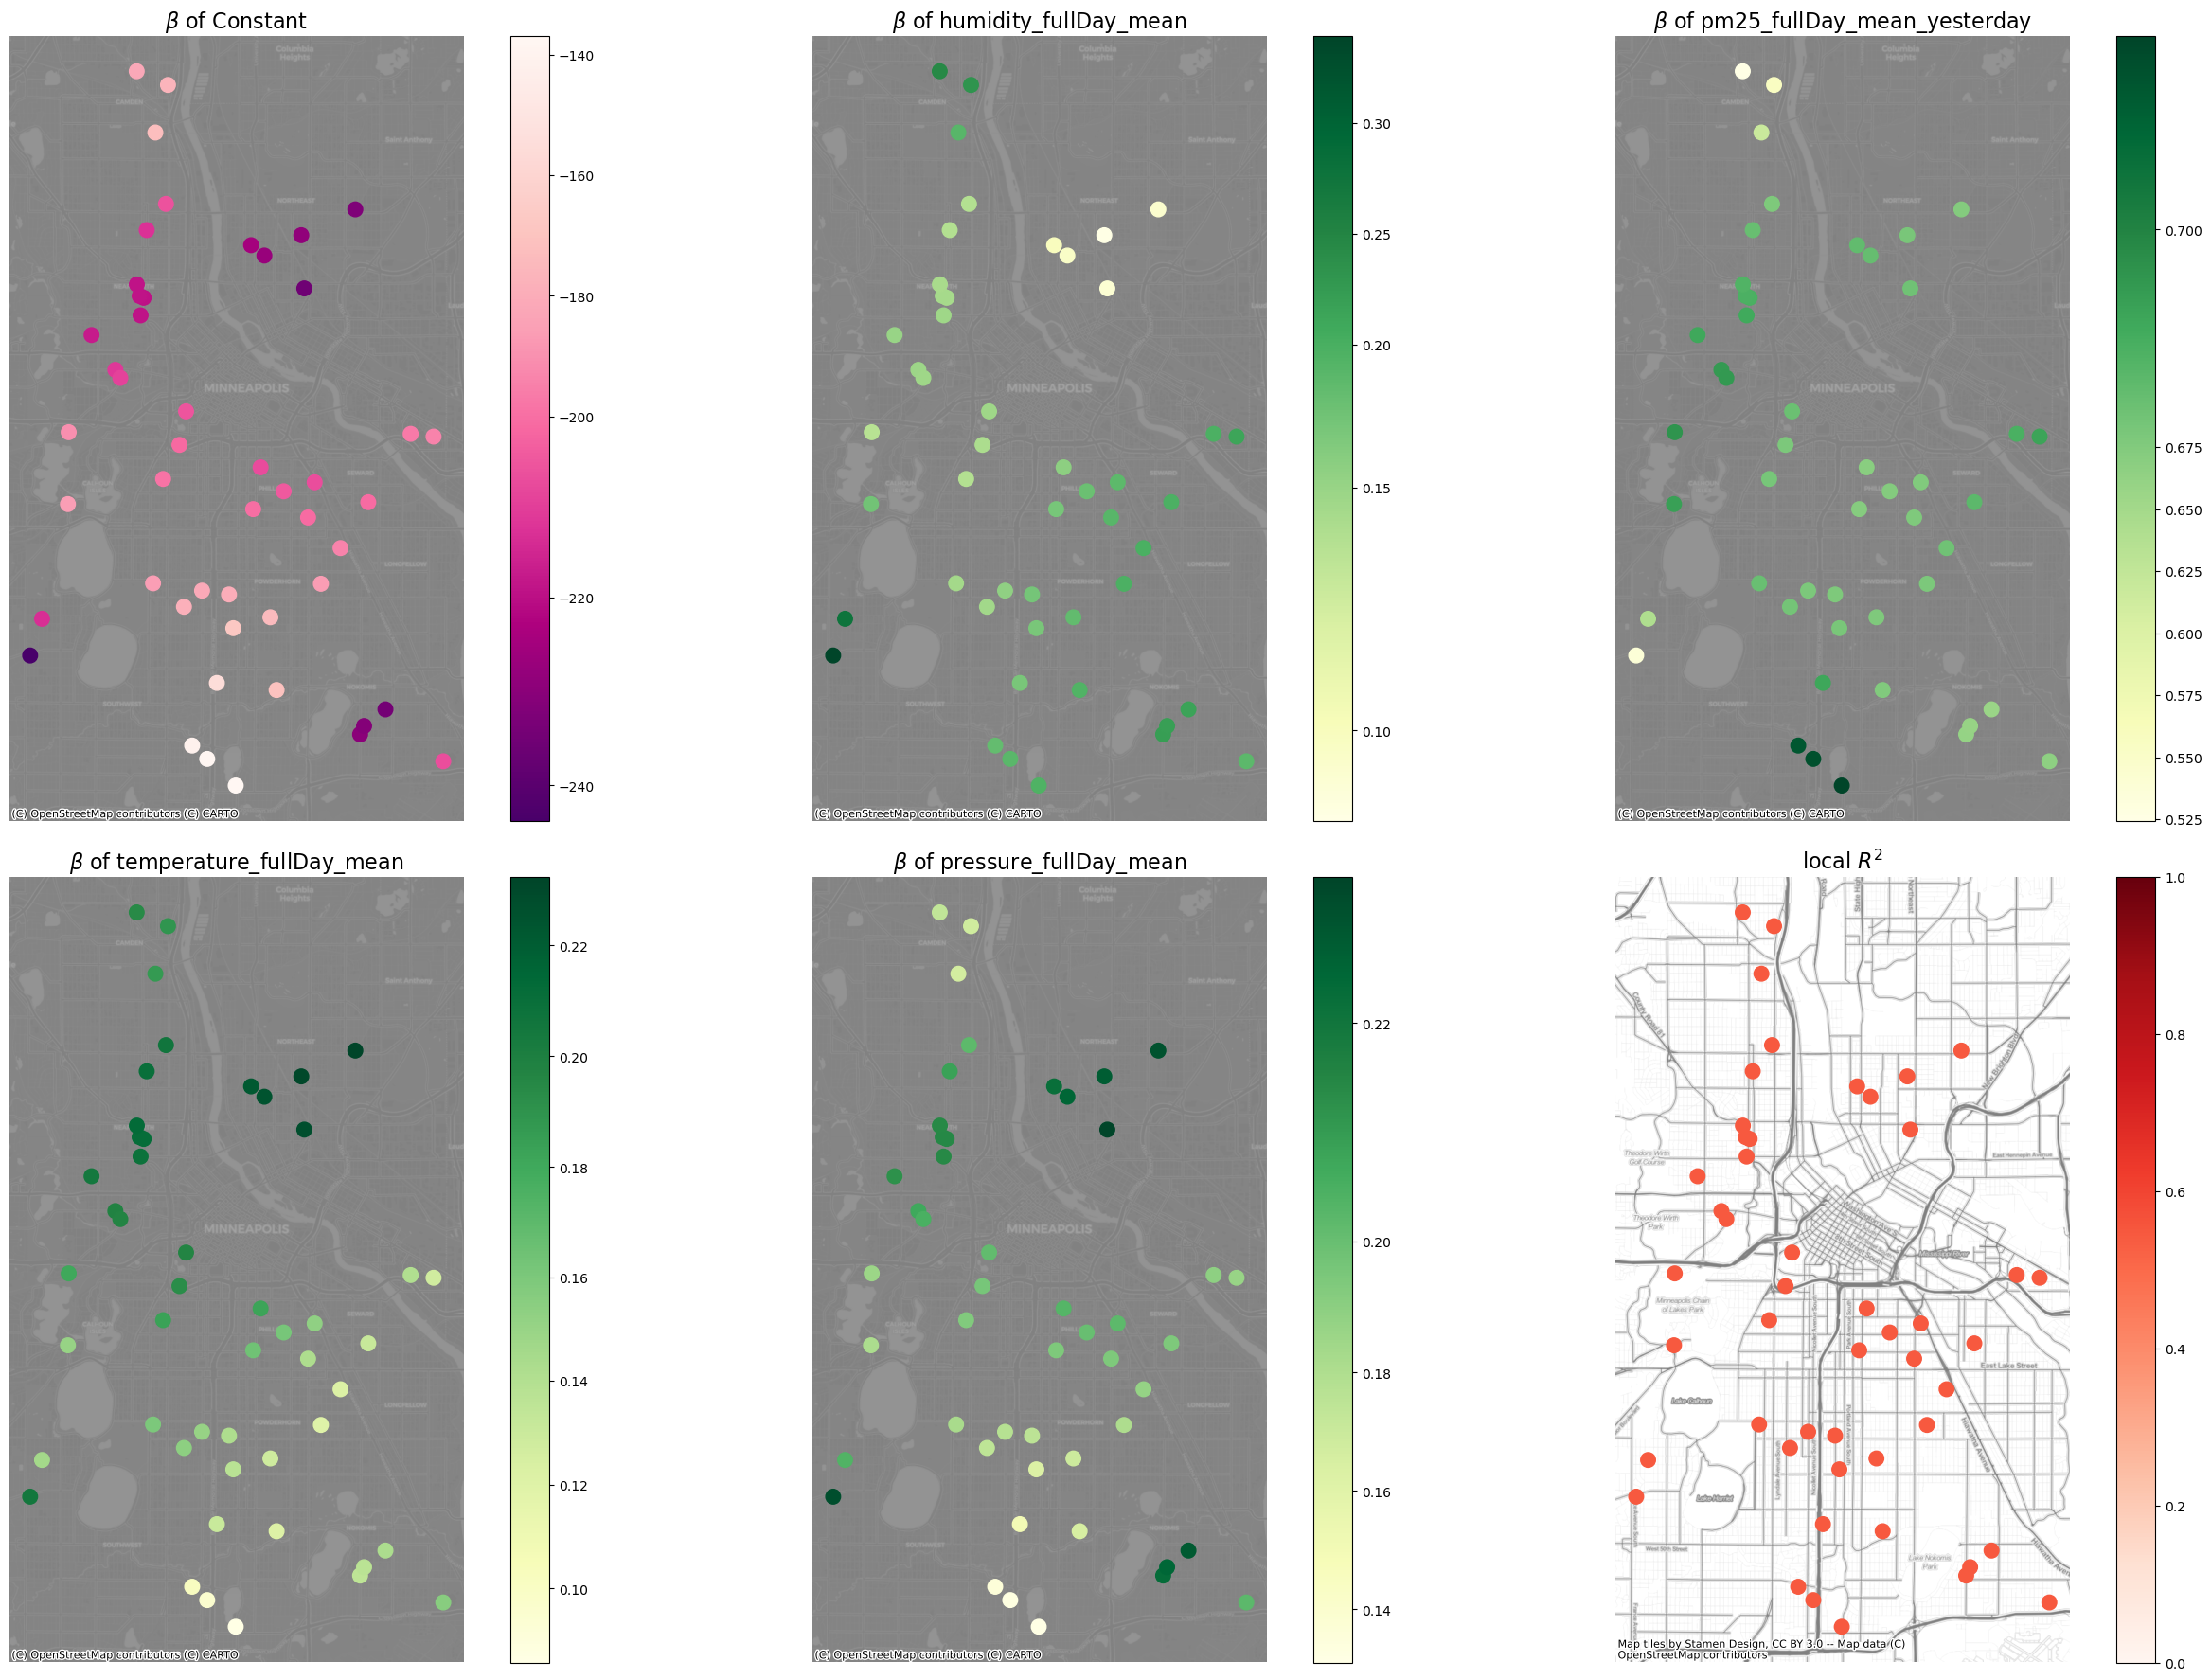

Spring 

~~~~~~~


Dependent Variables: 
 humidity_fullDay_mean
pm25_fullDay_mean_yesterday 


Model type                                                         Gaussian
Number of observations:                                                2708
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         109802.875
Log-likelihood:                                                   -8855.639
AIC:                                                              17717.277
AICc:                                                             17719.292
BIC:                                                              88422.648
R2:                                                                   0.163
Adj. R2:                                                              0.162

Variable                              Est

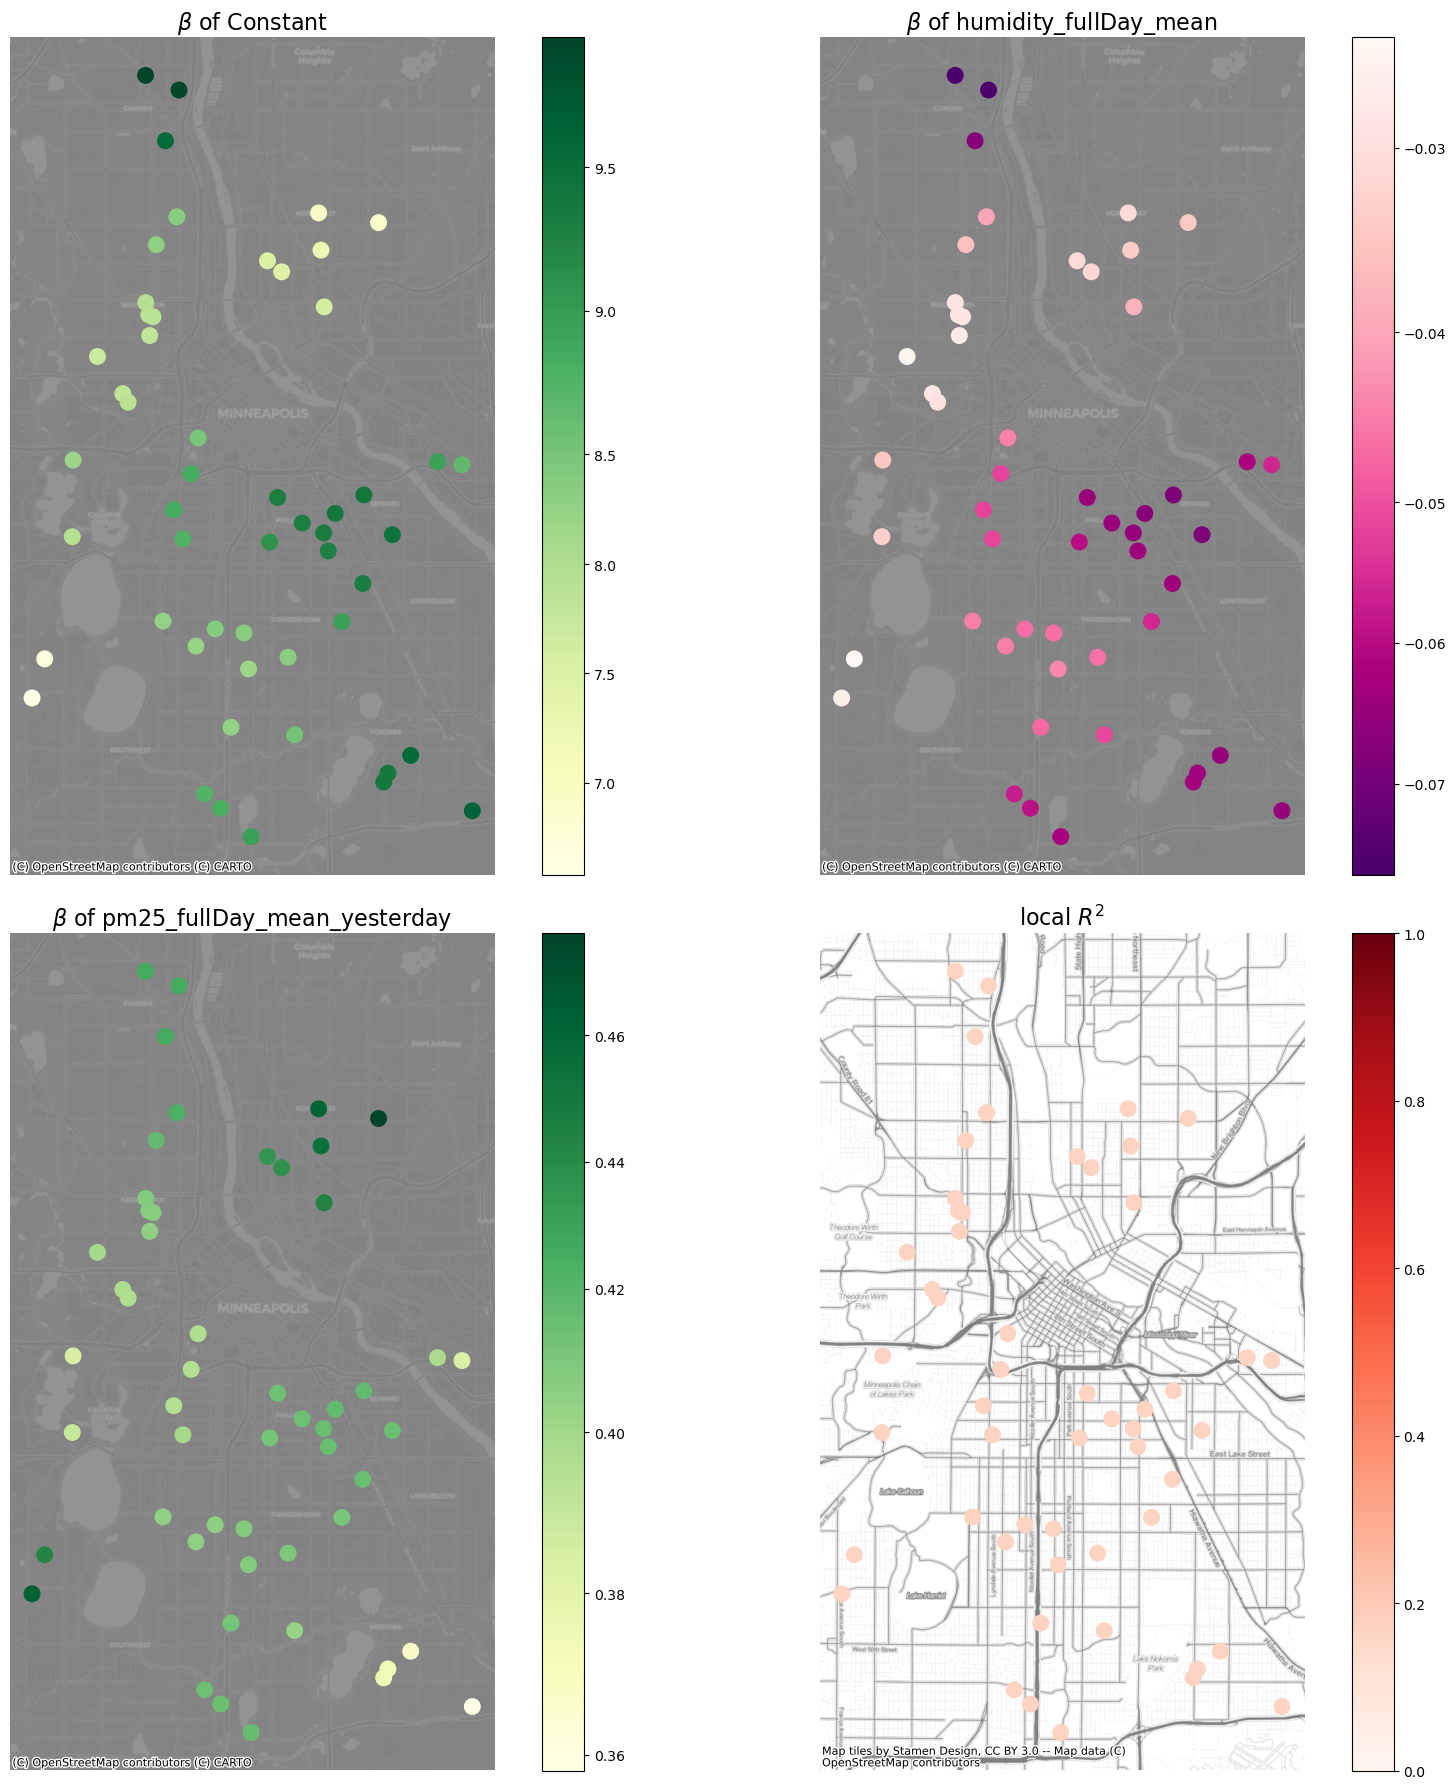

Summer 

~~~~~~~


Dependent Variables: 
 humidity_fullDay_mean
pm25_fullDay_mean_yesterday
temperature_fullDay_mean
pressure_fullDay_mean
idwSum_traffic 


Model type                                                         Gaussian
Number of observations:                                                1261
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          19667.287
Log-likelihood:                                                   -3521.298
AIC:                                                               7054.595
AICc:                                                              7056.684
BIC:                                                              10707.013
R2:                                                                   0.188
Adj. R2:                                                

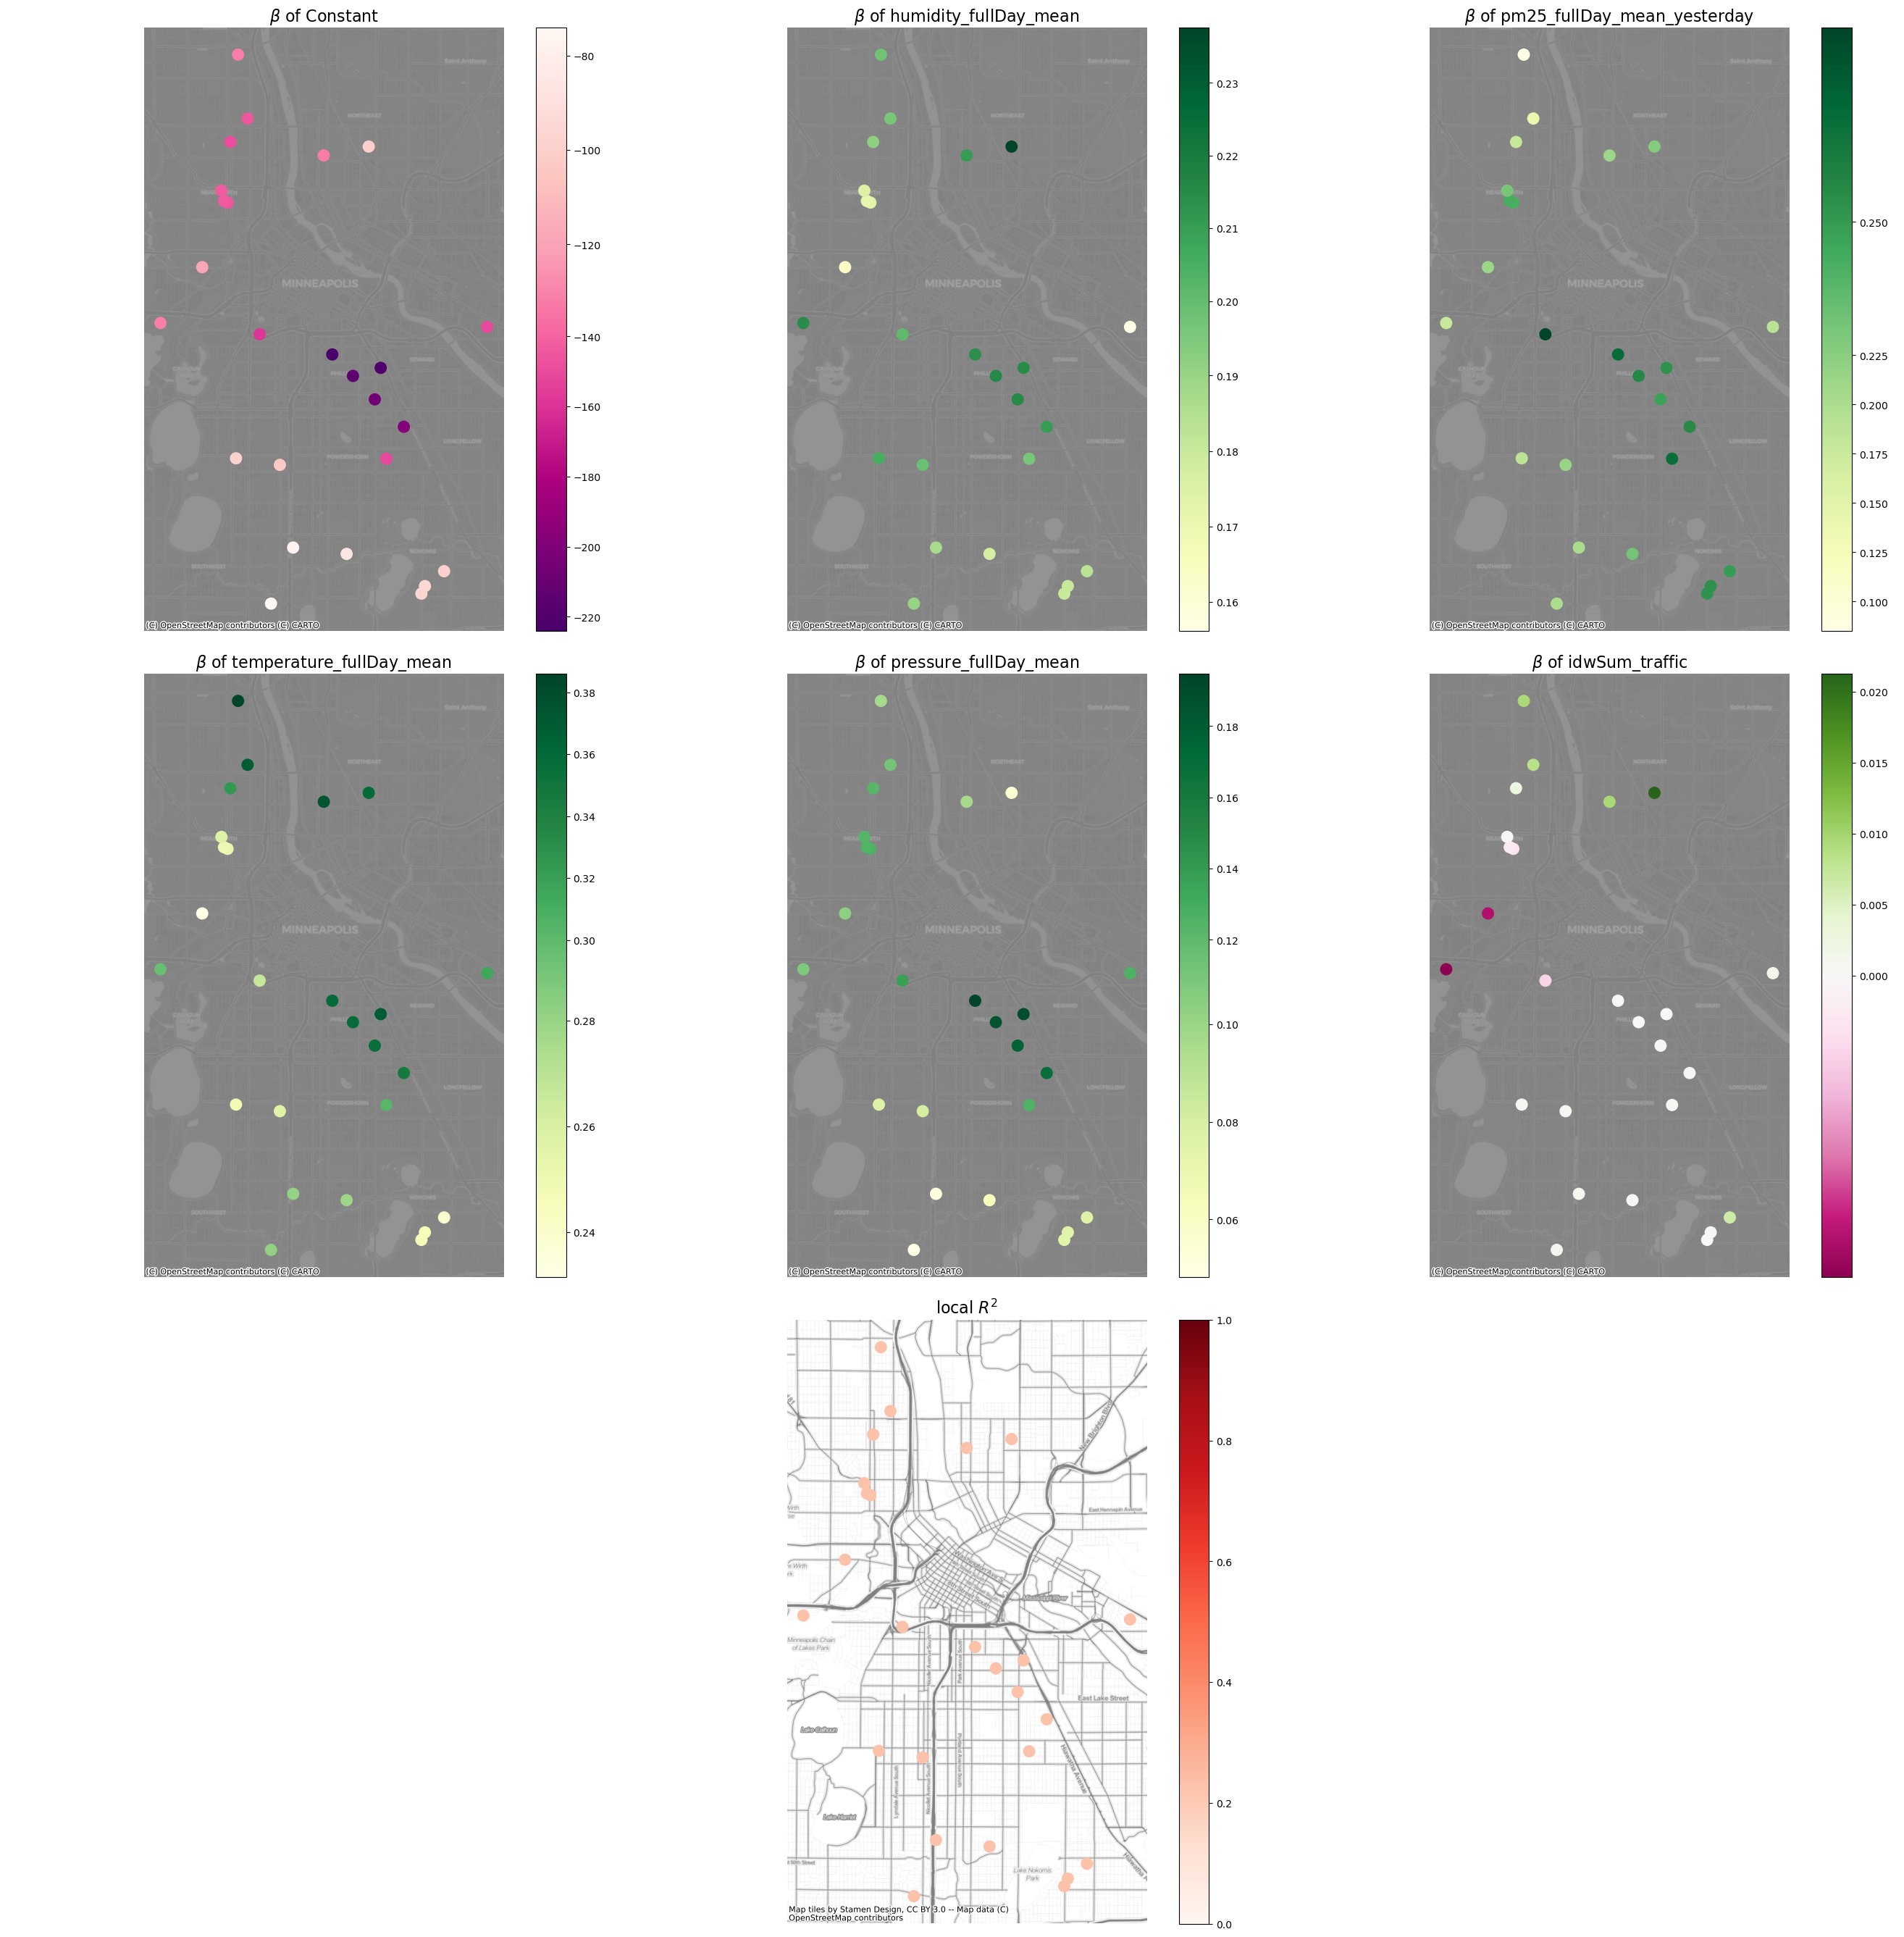

Fall 

~~~~~~~


Dependent Variables: 
 humidity_fullDay_mean
pm25_fullDay_mean_yesterday 


Model type                                                         Gaussian
Number of observations:                                                2432
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         206823.890
Log-likelihood:                                                   -8853.733
AIC:                                                              17713.467
AICc:                                                             17715.483
BIC:                                                             187886.266
R2:                                                                   0.348
Adj. R2:                                                              0.348

Variable                              Est. 

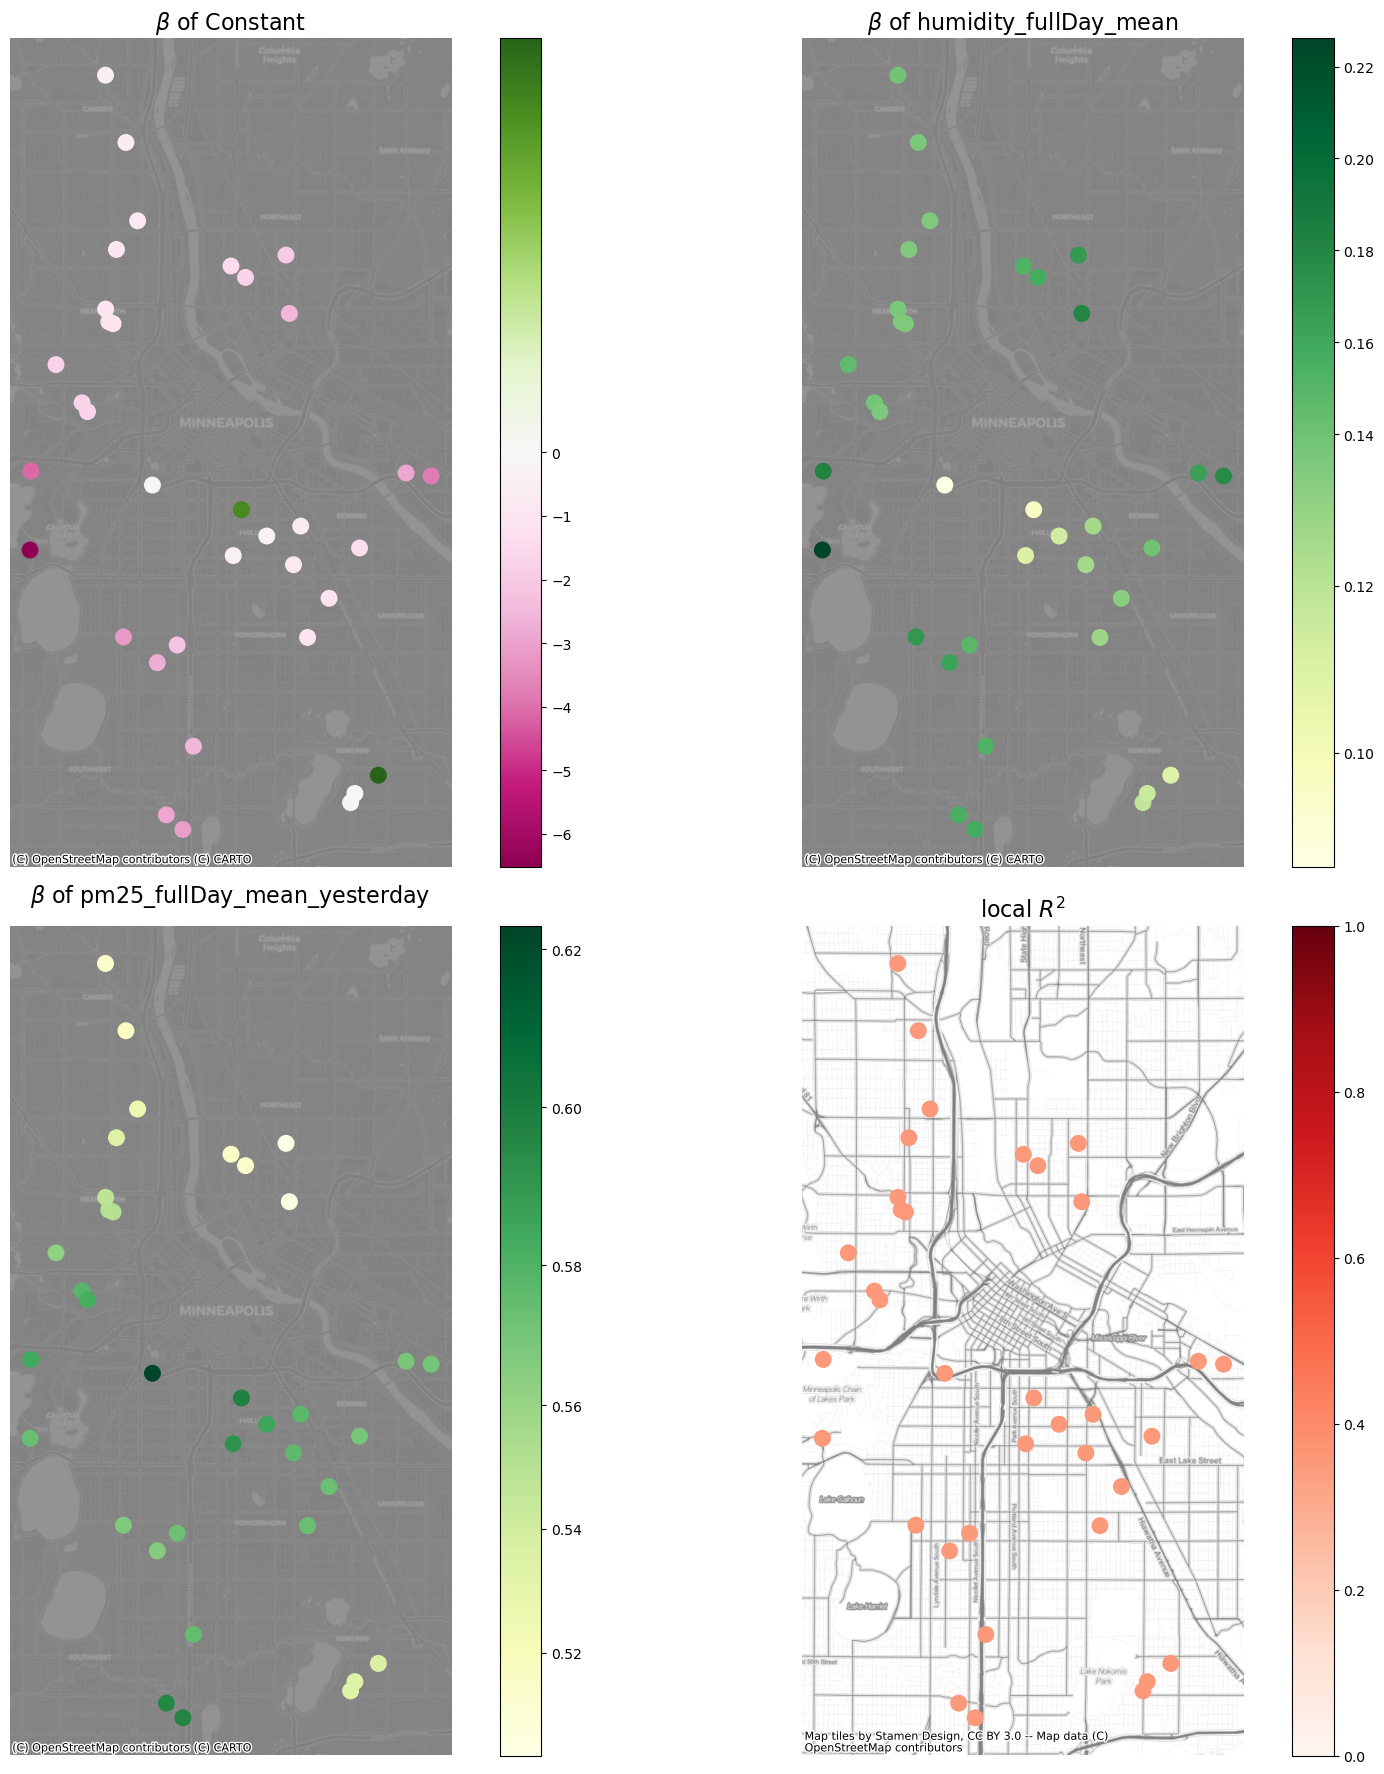

All 

~~~~~~~


Dependent Variables: 
 humidity_fullDay_mean
pm25_fullDay_mean_yesterday 


Model type                                                         Gaussian
Number of observations:                                                9821
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         879515.872
Log-likelihood:                                                  -36007.350
AIC:                                                              72020.699
AICc:                                                             72022.703
BIC:                                                             789266.084
R2:                                                                   0.480
Adj. R2:                                                              0.480

Variable                              Est.  

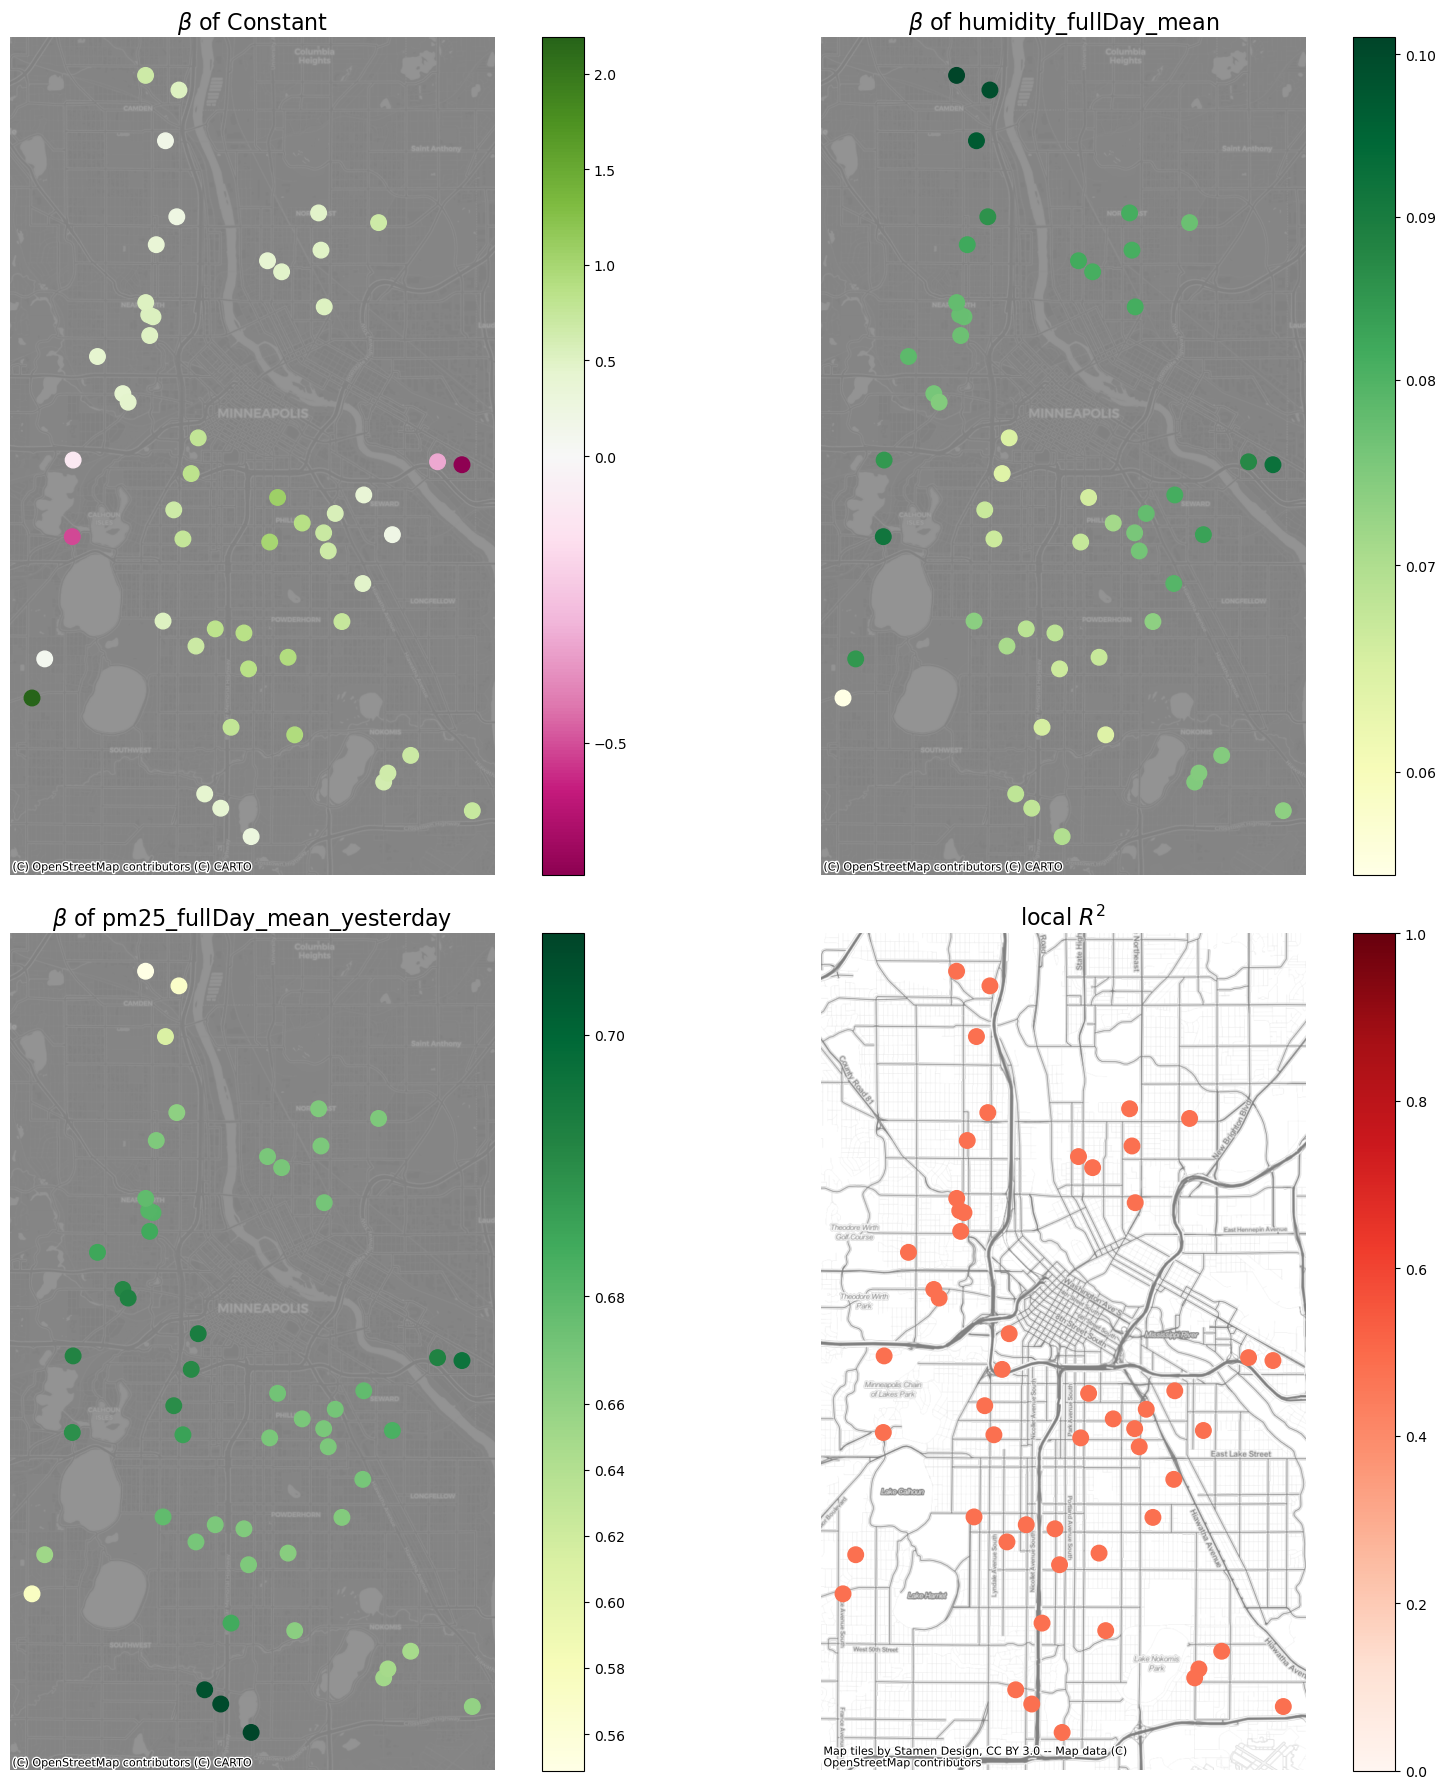

In [16]:
# Check them out!

for season in season_bests:

    # Get the model information
    
    combo_key = season_bests[season][0] # Key in the model dictionary
    
    combo_id = int(combo_key.split('_')[0]) # Key in the predictor combos dictionary
    
    x_names = list(combos_dict[combo_id]) # Predictors
    
    results = model_dict[season][combo_key]
    
    print(season, '\n\n~~~~~~~\n\n')
    
    print('Dependent Variables: \n', '\n'.join(x_names), '\n\n')
    
    print(results.summary())
    
    # Plot?!
    
    # Add parameters to a geodataframe
    
    betas = results.params
    
    gdf = model_dict[season]['utm_gdf'].copy()[['sensor_index', 
                                                'name', 'latitude', 
                                                'longitude', 'geometry']]
    
    for i, name in enumerate(['constant'] + x_names):
        
        coef_name = name + '_beta'
        
        gdf.loc[:, coef_name] = betas.T[i]
        
    gdf.loc[:, 'r2'] = results.R2
        
    # Drop the duplicate rows
    
    gdf = gdf.drop_duplicates(ignore_index = True).copy()

    plot_GWR(gdf , x_names, 'GWR - ' + season)

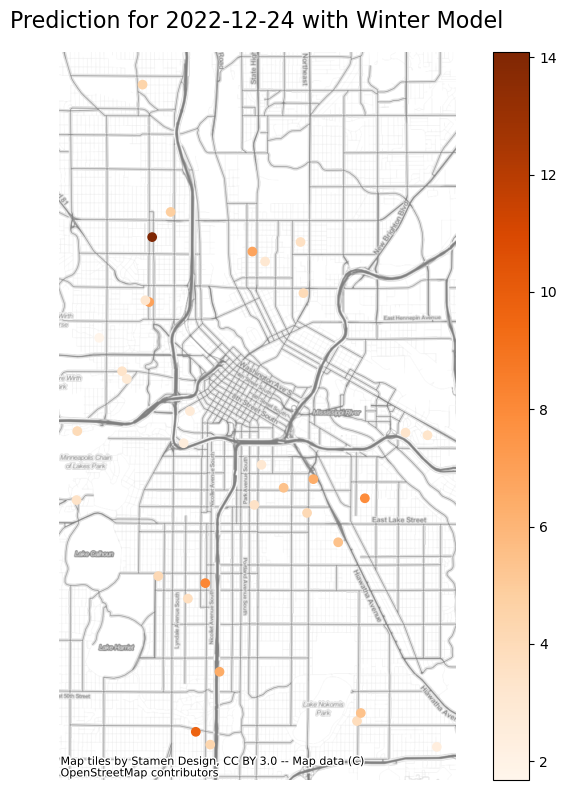

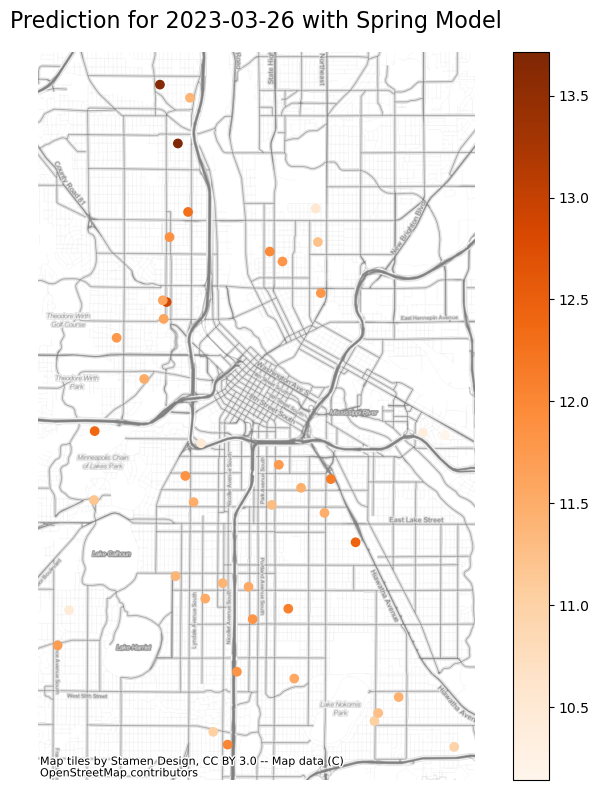

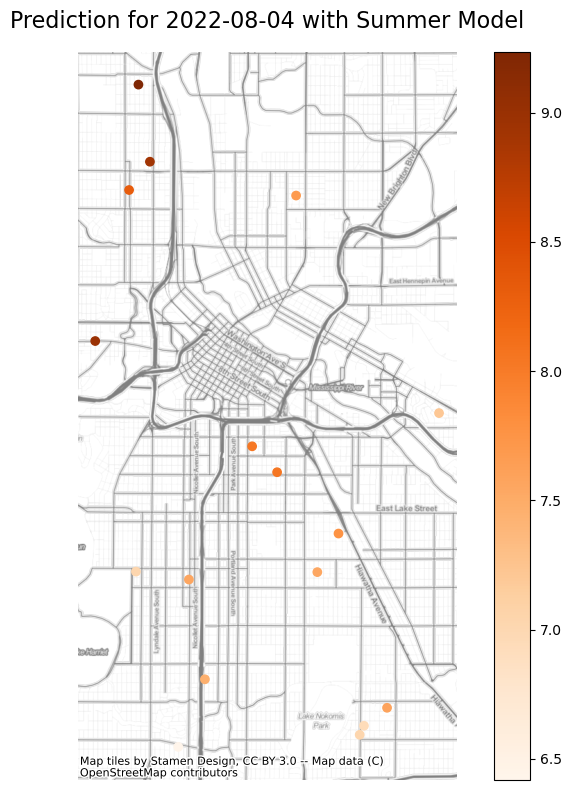

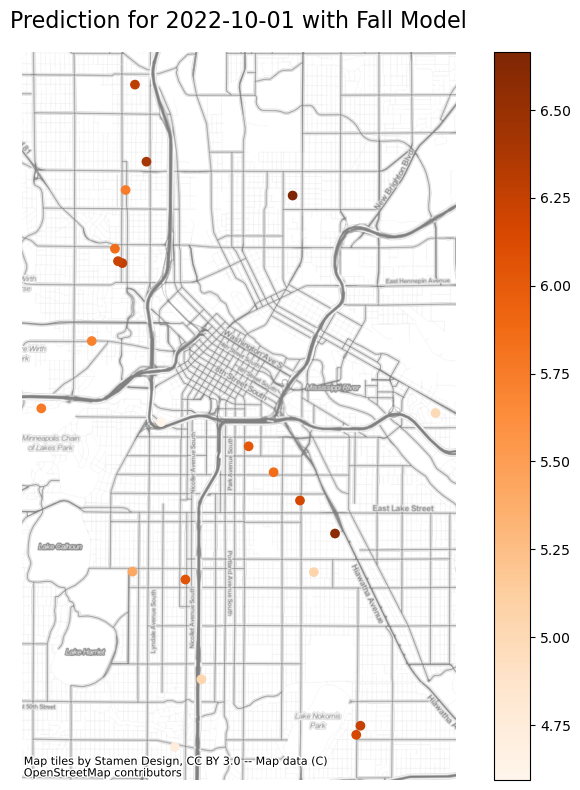

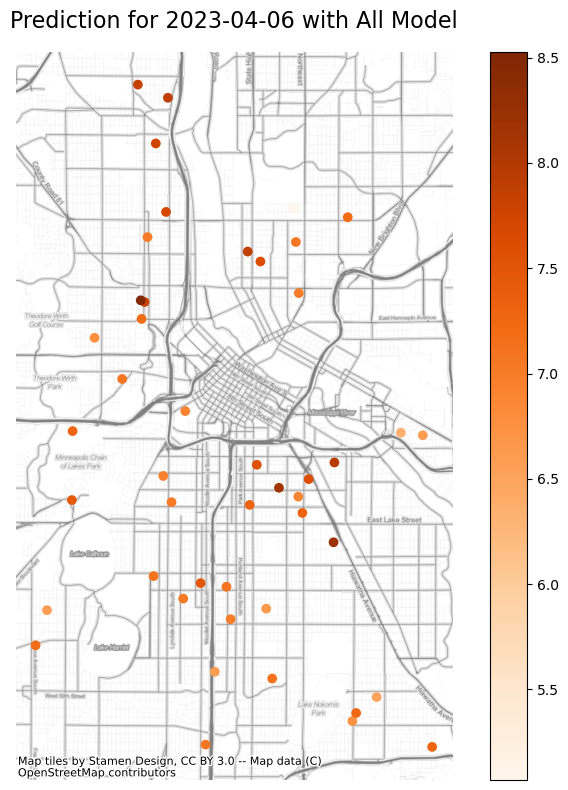

In [17]:
# Pretend forecast!? - Bootstrapping

# To actually predict, we may need to do something with this
# https://mgwr.readthedocs.io/en/latest/generated/mgwr.gwr.GWR.predict.html

# Bootstrapping the intial parameters

# init_params = 
# {
# 'humidity_fullDay_mean' = 85
# 'pm25_fullDay_mean_yesterday' = 12
# 'temperature_fullDay_mean' = 75
# 'pressure_fullDay_mean' = 1000
# }

for season in season_bests:
    
    # Select historic season information
    if season == 'All':
        season_data = merged_no_nans
    else:
        season_data = merged_no_nans[merged_no_nans.season == season]
        
    # Select a random day (Bootstrapping)
    
    index = np.random.randint(len(season_data))
    
    date = season_data.iloc[index].date
    
    day_data = season_data[season_data.date == date].drop('geometry',axis = 'columns')

    # Get the model information
    
    combo_key = season_bests[season][0] # Key in the model dictionary
    
    combo_id = int(combo_key.split('_')[0]) # Key in the predictor combos dictionary
    
    x_names = list(combos_dict[combo_id]) # Predictors
    
    betas = model_dict[season][combo_key].params # betas
    
    # Add parameters to a geodataframe
    
    beta_names = []
    
    gdf = model_dict[season]['utm_gdf'].copy()[['sensor_index', 
                                                'name', 'latitude', 
                                                'longitude', 'geometry']]
    
    for i, name in enumerate(['constant'] + x_names):
        
        coef_name = name + '_beta'
        
        beta_names += [coef_name]
        
        gdf.loc[:, coef_name] = betas.T[i]
        
    # Drop the duplicate rows
    
    model = gdf.drop_duplicates(ignore_index = True).copy()
    
    # This needs to be bootstrapping and merged with gdf above
    
    # Merge model with modeling_df
    
    merged = pd.merge(model, day_data, on = 'sensor_index')
    merged['constant'] = 1 # Add a constant column
    
    # Apply the model
    
    betas = merged[beta_names].values
    X = merged[['constant']+x_names].values
    
    merged['pm25_fullDay_mean_Prediction'] = np.sum(betas * X, axis = 1)
    
    
    # Plot the results
    
    f, ax = plt.subplots(1,1, figsize = (8,8))
                
    merged.plot(column = 'pm25_fullDay_mean_Prediction',
                     cmap = 'Oranges', legend = True, ax = ax)

    # base map
    ctx.add_basemap(ax = ax,
                    crs=merged.crs,
                    source=ctx.providers.Stamen.TonerHybrid,
                    zorder=-1,
                    alpha=0.5)

    # title
    ax.set_title('Prediction for ' + str(date.date()) + ' with ' + season + ' Model',fontsize=16)
            
    ax.set_axis_off() # Remove Axis labels

    f.tight_layout() # we are done!
    plt.show()


## Save

In [132]:
# Save

for season in season_bests:

    # Get the model information
    
    combo_key = season_bests[season][0] # Key in the model dictionary
    
    combo_id = int(combo_key.split('_')[0]) # Key in the predictor combos dictionary
    
    x_names = list(combos_dict[combo_id]) # Predictors
    
    betas = model_dict[season][combo_key].params # betas
    
    # Add the betas to a geodataframe
    
    gdf = model_dict[season]['utm_gdf'].copy()[['sensor_index', 
                                                'name', 'latitude', 
                                                'longitude', 'geometry']]
    
    for i, name in enumerate(['constant'] + x_names):
        
        coef_name = name + '_beta'
        
        gdf.loc[:, coef_name] = betas.T[i]
        
        
    # Drop the duplicate rows
    
    gdf = gdf.drop_duplicates(ignore_index = True).copy()
    
    # Save as a geojson
    
    name = season + '_bestModel.geojson'
    
    gdf.to_file(name)